Origin-destination matrices comparisons

## KSH measures

In [51]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import computing_functions

In [52]:
ksh_stats = pd.read_csv("data/sources/KSH/KSHSettlList_settlID_settlname_pop_lat_lon.csv")
ksh_flows_16 = pd.read_csv("data/sources/KSH/flows_16_cities.csv")
gravity_base = pd.read_csv("computing/odm/ODM_16_cities_gravity_unfitted.csv")
gravity_fitted = pd.read_csv("computing/odm/ODM_16_cities_gravity_fitted.csv")
entopy_max = (pd.read_csv("computing/odm/ODM_16_cities_entropy_max.csv")).rename(columns={"ODM_value": "flow"})
entopy_min = (pd.read_csv("computing/odm/ODM_16_cities_entropy_min.csv")).rename(columns={"ODM_value": "flow"})
cities = ['Budapest', 'Kecskemét', 'Szeged', 'Szolnok', 'Debrecen', 'Nyíregyháza', 'Miskolc', 'Dunaújváros', 'Szekszárd', 'Pécs', 'Székesfehérvár', 'Siófok', 'Győr', 'Sopron', 'Szombathely', 'Veszprém']

def replace_letters(s):
    return s.replace("õ", "ő").replace("Õ", "Ő").replace("û", "ű").replace("Û", "Ű")
#non_english_letters = r'[^a-zA-Z]'; non_hungarian_letters = r'[^a-zA-ZáéíóöőúüűÁÉÍÓÖŐÚÜŰ]'
#non_hungarian = ksh_stats['Settlement_Name'].str.contains(non_hungarian_str, regex=True)
ksh_stats['Settlement_Name'] = ksh_stats['Settlement_Name'].apply(replace_letters)

In [53]:
ksh_flows_16_nondiagonal = ksh_flows_16.copy()
for i, row in ksh_flows_16_nondiagonal.iterrows():
    if row['origin'] == row['destination']:
        ksh_flows_16_nondiagonal.loc[i, "flow"] = 0

In [54]:
def generate_id_dicts(ksh_flows_dir, origin_column_name='origName',origin_column_ID ='origID'):
    place_id_dict = {}
    for key, value in zip(ksh_flows_dir[origin_column_name], ksh_flows_dir[origin_column_ID]):
        if key in place_id_dict.keys():
            if place_id_dict[key] != value:
                print(key), print(value), print(place_id_dict[key])
        else:
            place_id_dict[key] = value
    place_id_dict['Budapest'] = 13578
    id_place_dict = { v:k for k, v in place_id_dict.items()}
    return place_id_dict, id_place_dict

place_id_dict, id_place_dict = generate_id_dicts(ksh_stats, 'Settlement_Name', 'Settlement_ID')

In [71]:
def odm_ids_df_to_odm_2d(odm_df, id_place_dict, places_sorted=None):
    if places_sorted is None:
        places_sorted = [id_place_dict[int(id)] for id in odm_df['destination'].unique()]
    odm_2d = np.zeros((len(places_sorted), len(places_sorted)))

    for i, row in odm_df.iterrows():
        origin = row['origin']; destination = row['destination']
        odm_2d[places_sorted.index(id_place_dict[origin]), places_sorted.index(id_place_dict[destination])] = row['flow']
    return odm_2d

def odm_ids_df_to_odm_2d_symmetric(odm_df, id_place_dict, places_sorted=None):
    if places_sorted is None:
        places_sorted = [id_place_dict[int(id)] for id in odm_df['destination'].unique()]
    odm_2d = np.zeros((len(places_sorted), len(places_sorted)))

    for i, row in odm_df.iterrows():
        origin = row['origin']; destination = row['destination']
        odm_2d[places_sorted.index(id_place_dict[origin]), places_sorted.index(id_place_dict[destination])] = row['flow']
        odm_2d[places_sorted.index(id_place_dict[destination]), places_sorted.index(id_place_dict[origin])] = row['flow']
    return odm_2d

def odm_location_names_df_to_odm_2d(odm_df, places_sorted=None):
    if places_sorted is None:
        places_sorted = list(np.sort([name for name in odm_df['destination'].unique()]))
    odm_2d = np.zeros((len(places_sorted), len(places_sorted)))

    for i, row in odm_df.iterrows():
        origin = row['origin']; destination = row['destination']
        odm_2d[places_sorted.index(origin), places_sorted.index(destination)] = row['flow']
    return odm_2d

def odm_location_names_df_to_odm_2d_symmetric(odm_df, places_sorted=None):
    if places_sorted is None:
        places_sorted = list(np.sort([name for name in odm_df['destination'].unique()]))
    odm_2d = np.zeros((len(places_sorted), len(places_sorted)))

    for i, row in odm_df.iterrows():
        origin = row['origin']; destination = row['destination']
        odm_2d[places_sorted.index(origin), places_sorted.index(destination)] = row['flow']
        odm_2d[places_sorted.index(destination), places_sorted.index(origin)] = row['flow']
    return odm_2d

odm_2d = odm_ids_df_to_odm_2d_symmetric(ksh_flows_16,id_place_dict, cities)
odm_2d_nondiagonal = odm_ids_df_to_odm_2d_symmetric(ksh_flows_16_nondiagonal,id_place_dict, cities)

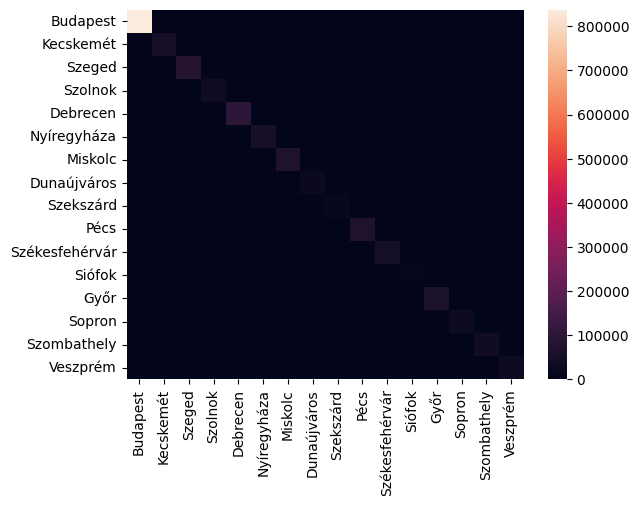

In [72]:
computing_functions.plot_odm(odm_2d, cities,)

Excluding the diagonal:

In [89]:
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
def plot_odm(odm_2d, locations, plot_type='heatmap', order = None):
    if plot_type == 'heatmap':
        sns.heatmap(odm_2d, xticklabels=locations, yticklabels=locations, norm=LogNorm())
        plt.show()
    elif plot_type == 'scatterplot':
        odm_long = odm_2d.reshape(-1)
        x = np.repeat(locations, len(locations))
        y = np.tile(locations, len(locations))
        if order is not None:
            odm_long = odm_long[order]
            x = x[order]
            y = y[order]
        sns.scatterplot(x=x, y=y, size=odm_long)
        plt.show()
    else:
        print(f"Unknown plot type: {plot_type}")#potential change to raise ValueError

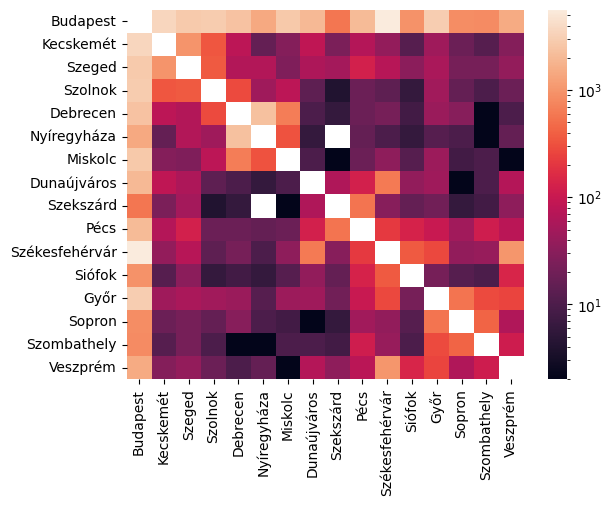

In [90]:
plot_odm(odm_2d_nondiagonal, cities,)

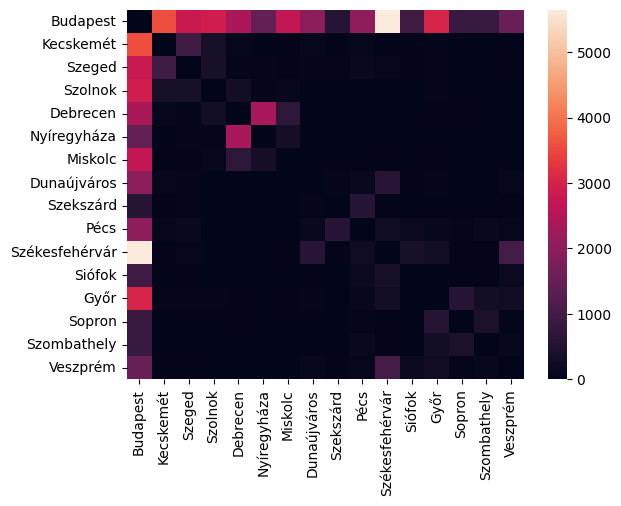

In [73]:
computing_functions.plot_odm(odm_2d_nondiagonal, cities,)

## Compare the computed ODMs 

In [74]:
odm_gravity_base = odm_location_names_df_to_odm_2d_symmetric(gravity_base, cities)
odm_gravity_fitted = odm_location_names_df_to_odm_2d_symmetric(gravity_fitted, cities)
odm_entropy_max = odm_location_names_df_to_odm_2d_symmetric(entopy_max, cities)
odm_entropy_min = odm_location_names_df_to_odm_2d_symmetric(entopy_min, cities)

In [75]:
import seaborn as sns
def plot_odm_axis(odm_2d, locations, plot_type='heatmap', order=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    if plot_type == 'heatmap':
        sns.heatmap(odm_2d, xticklabels=locations, yticklabels=locations, ax=ax)
    elif plot_type == 'scatterplot':
        odm_long = odm_2d.reshape(-1)
        x = np.repeat(locations, len(locations))
        y = np.tile(locations, len(locations))
        if order is not None:
            odm_long = odm_long[order]
            x = x[order]
            y = y[order]
        sns.scatterplot(x=x, y=y, size=odm_long, ax=ax)
    else:
        print(f"Unknown plot type: {plot_type}")  # potential change to raise ValueError

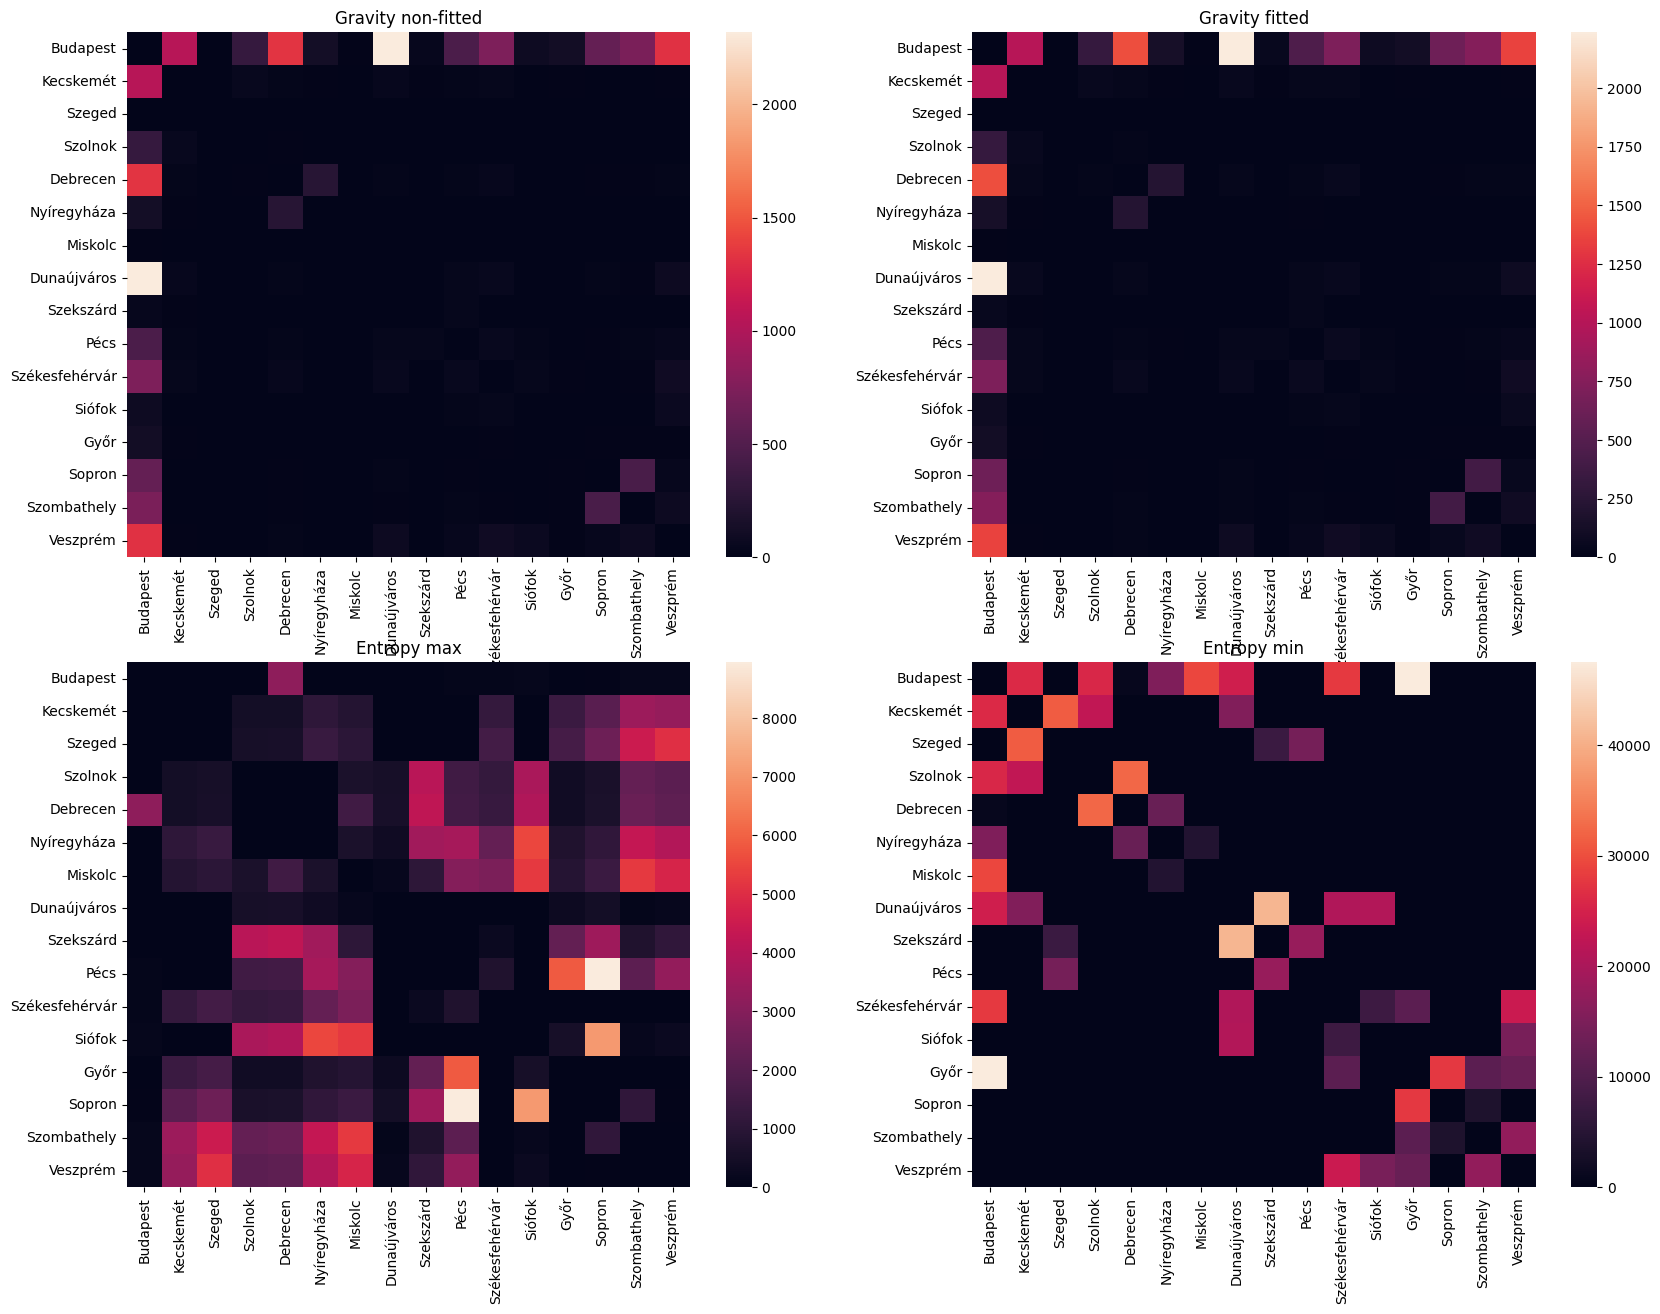

In [76]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
plot_odm_axis(odm_gravity_base, cities, ax=axs[0, 0])
plot_odm_axis(odm_gravity_fitted, cities, ax=axs[0, 1])
plot_odm_axis(odm_entropy_max, cities, ax=axs[1, 0])
plot_odm_axis(odm_entropy_min, cities, ax=axs[1, 1])

axs[0, 0].set_title('Gravity non-fitted')
axs[0, 1].set_title('Gravity fitted')
axs[1, 0].set_title('Entropy max')
axs[1, 1].set_title('Entropy min');


Difference plots:

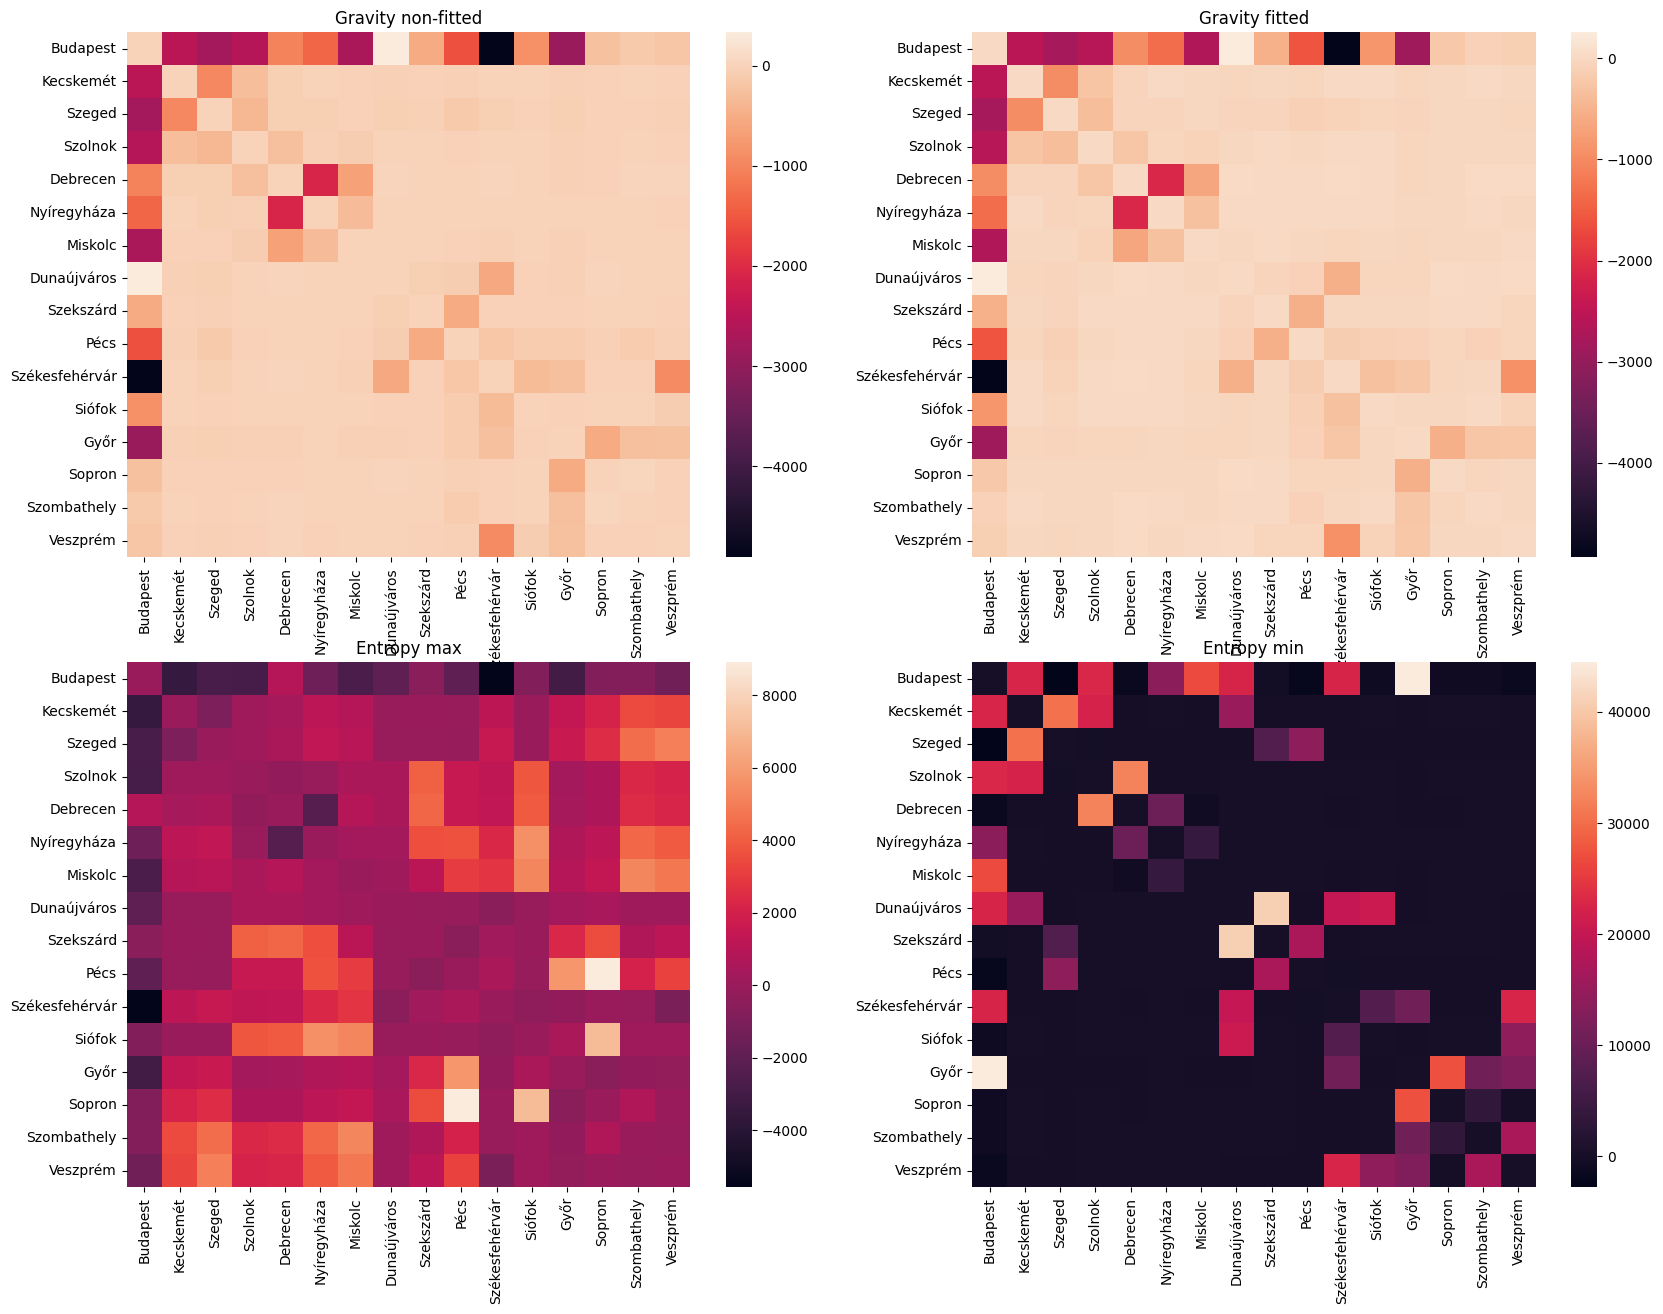

In [77]:
#Plot the 4 ODMs in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
plot_odm_axis(odm_gravity_base-odm_2d_nondiagonal, cities, ax=axs[0, 0])
plot_odm_axis(odm_gravity_fitted-odm_2d_nondiagonal, cities, ax=axs[0, 1])
plot_odm_axis(odm_entropy_max-odm_2d_nondiagonal, cities, ax=axs[1, 0])
plot_odm_axis(odm_entropy_min-odm_2d_nondiagonal, cities, ax=axs[1, 1])

#Set titles
axs[0, 0].set_title('Gravity non-fitted')
axs[0, 1].set_title('Gravity fitted')
axs[1, 0].set_title('Entropy max')
axs[1, 1].set_title('Entropy min');


Normalize to equal total flow: Set the models to have equal total flow as the original odm_2d_nondiagonal

In [78]:
def set_total_flow(odm, total_flow):
    return odm/np.sum(odm)*total_flow

total_flow = np.sum(odm_2d_nondiagonal)
odm_gravity_base_normalized = set_total_flow(odm_gravity_base, total_flow)
odm_gravity_fitted_normalized = set_total_flow(odm_gravity_fitted, total_flow)
odm_entropy_max_normalized = set_total_flow(odm_entropy_max, total_flow)
odm_entropy_min_normalized = set_total_flow(odm_entropy_min, total_flow)


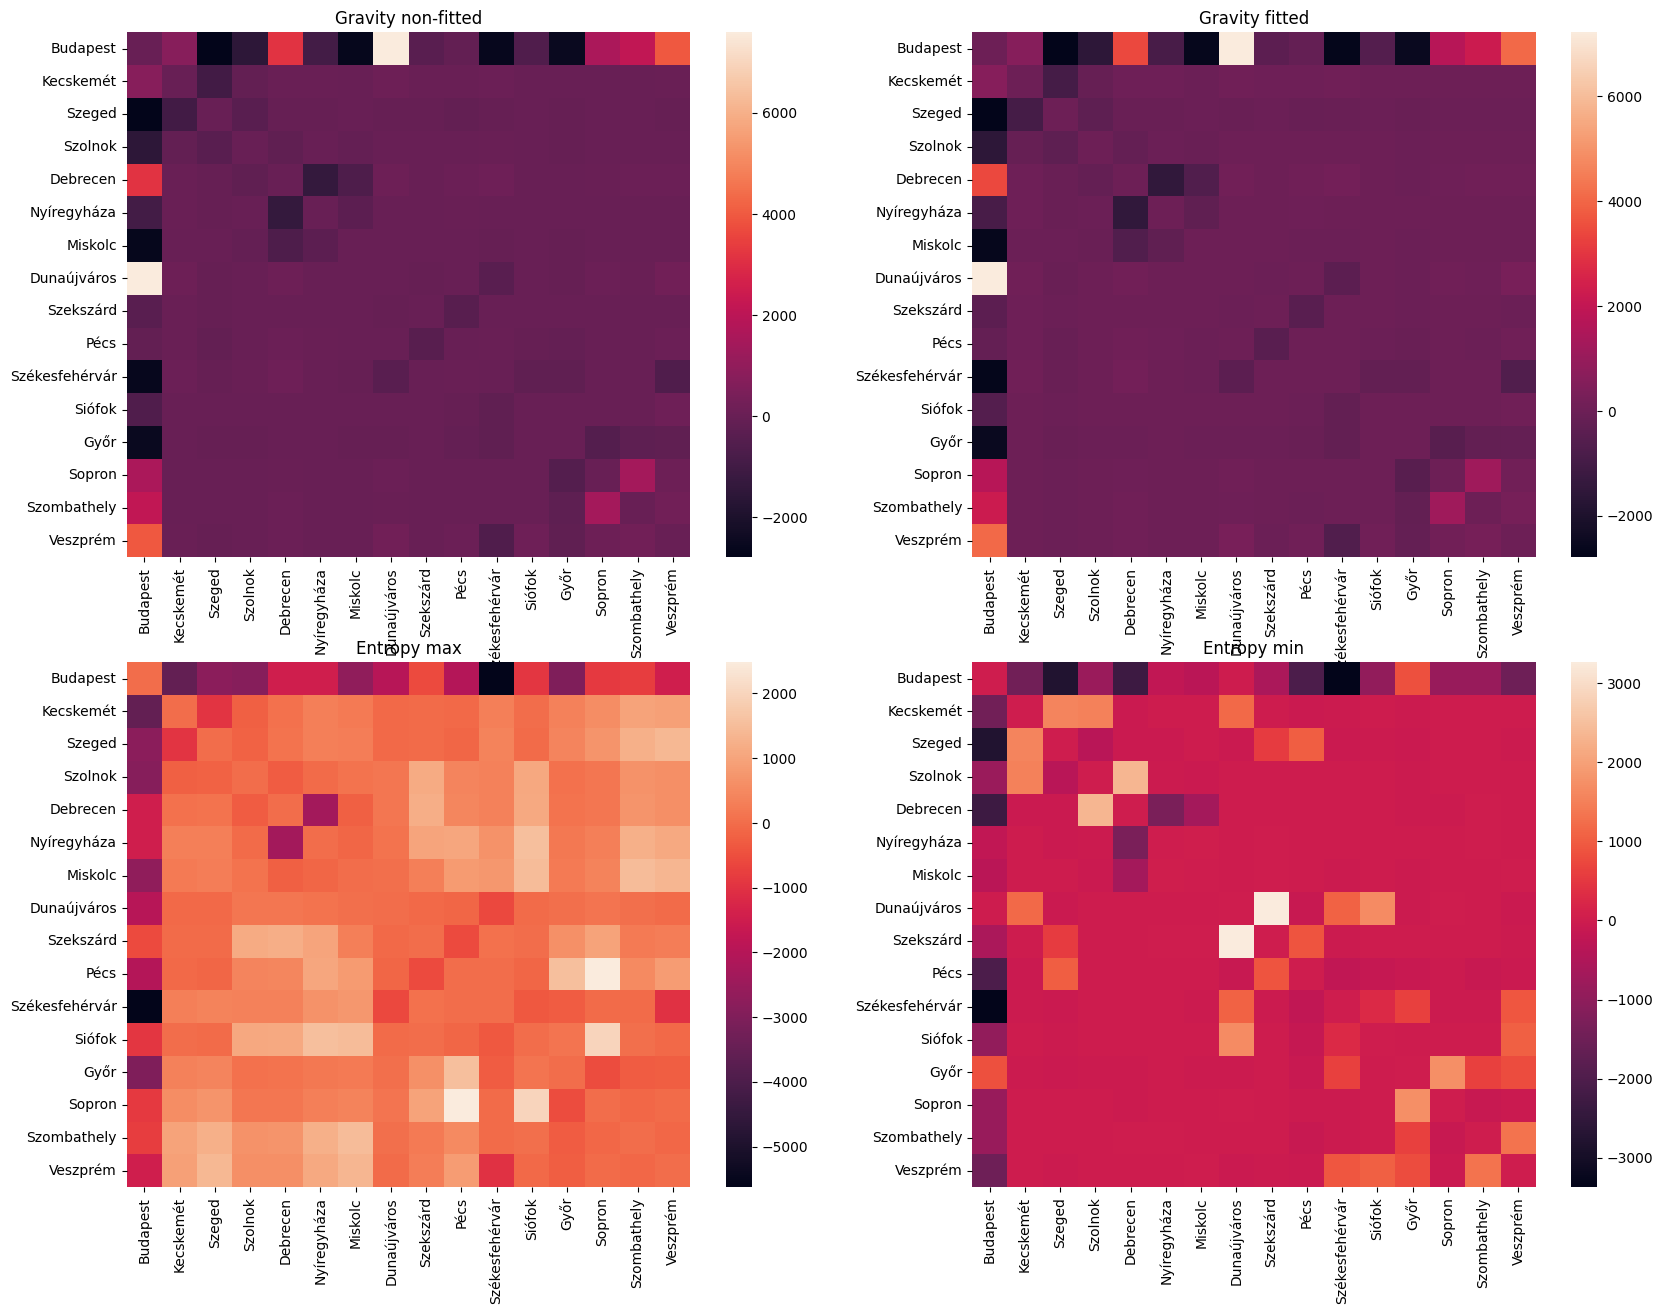

In [79]:
#Plot the 4 ODMs in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
plot_odm_axis(odm_gravity_base_normalized-odm_2d_nondiagonal, cities, ax=axs[0, 0])
plot_odm_axis(odm_gravity_fitted_normalized-odm_2d_nondiagonal, cities, ax=axs[0, 1])
plot_odm_axis(odm_entropy_max_normalized-odm_2d_nondiagonal, cities, ax=axs[1, 0])
plot_odm_axis(odm_entropy_min_normalized-odm_2d_nondiagonal, cities, ax=axs[1, 1])

#Set titles
axs[0, 0].set_title('Gravity non-fitted')
axs[0, 1].set_title('Gravity fitted')
axs[1, 0].set_title('Entropy max')
axs[1, 1].set_title('Entropy min');


In [81]:
from sklearn.metrics import mean_squared_error

mse_gravity = mean_squared_error(odm_2d_nondiagonal.flatten(), odm_gravity_base_normalized.flatten())
mse_gravity_fitted = mean_squared_error(odm_2d_nondiagonal.flatten(), odm_gravity_fitted_normalized.flatten())
mse_entropy_max = mean_squared_error(odm_2d_nondiagonal.flatten(), odm_entropy_max_normalized.flatten())
mse_entropy_min = mean_squared_error(odm_2d_nondiagonal.flatten(), odm_entropy_min_normalized.flatten())

print(f'MSE for Gravity non-fitted: {mse_gravity}')
print(f'MSE for Gravity fitted: {mse_gravity_fitted}')
print(f'MSE for Entropy max: {mse_entropy_max}')
print(f'MSE for Entropy min: {mse_entropy_min}')

MSE for Gravity non-fitted: 1014652.4847475761
MSE for Gravity fitted: 1000910.4368519709
MSE for Entropy max: 1154118.209642847
MSE for Entropy min: 593503.0654749919


In [84]:
from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error

mse_gravity = mean_squared_error(odm_2d_nondiagonal.flatten(), odm_gravity_base_normalized.flatten())
mse_gravity_fitted = mean_squared_error(odm_2d_nondiagonal.flatten(), odm_gravity_fitted_normalized.flatten())
mse_entropy_max = mean_squared_error(odm_2d_nondiagonal.flatten(), odm_entropy_max_normalized.flatten())
mse_entropy_min = mean_squared_error(odm_2d_nondiagonal.flatten(), odm_entropy_min_normalized.flatten())

print(f'MSE for Gravity non-fitted: {mse_gravity}')
print(f'MSE for Gravity fitted: {mse_gravity_fitted}')
print(f'MSE for Entropy max: {mse_entropy_max}')
print(f'MSE for Entropy min: {mse_entropy_min}')
corr_gravity, _ = pearsonr(odm_2d_nondiagonal.flatten(), odm_gravity_base_normalized.flatten())
corr_gravity_fitted, _ = pearsonr(odm_2d_nondiagonal.flatten(), odm_gravity_fitted_normalized.flatten())
corr_entropy_max, _ = pearsonr(odm_2d_nondiagonal.flatten(), odm_entropy_max_normalized.flatten())
corr_entropy_min, _ = pearsonr(odm_2d_nondiagonal.flatten(), odm_entropy_min_normalized.flatten())

print(f'Correlation for Gravity non-fitted: {corr_gravity}')
print(f'Correlation for Gravity fitted: {corr_gravity_fitted}')
print(f'Correlation for Entropy max: {corr_entropy_max}')
print(f'Correlation for Entropy min: {corr_entropy_min}')

Correlation for Gravity non-fitted: 0.5741405655844586
Correlation for Gravity fitted: 0.5704050042278528
Correlation for Entropy max: -0.23136694449293665
Correlation for Entropy min: 0.5560296322943596


In [88]:
table = {
    'Model': ['Gravity non-fitted', 'Gravity fitted', 'Entropy max', 'Entropy min'],
    'MSE': [int(mse_gravity), int(mse_gravity_fitted), int(mse_entropy_max), int(mse_entropy_min)],
    'Correlation': [corr_gravity, corr_gravity_fitted, corr_entropy_max, corr_entropy_min],
    'Note': ['Geographical closeness bias', 'Not much difference to non-fitted', 'Bias on far distances', 'Bias on directly connected cities']
}

df = pd.DataFrame(table)
df

,Model,MSE,Correlation,Note
0,Gravity non-fitted,1014652,0.574141,Geographical closeness bias
1,Gravity fitted,1000910,0.570405,Not much difference to non-fitted
2,Entropy max,1154118,-0.231367,Bias on far distances
3,Entropy min,593503,0.556030,Bias on directly connected cities
